In [1]:
import os
import pprint
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch

data_folder = os.path.join(".", os.pardir, os.pardir, "data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

print(data_folder)
print(raw_data_folder)


./../../data
./../../data/RAW


## ARotor replication (newer dataset)

Kongsberg test rig

### Faults


In [21]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Faults")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if not filename[0] == ".":
            # print(dirpath, filename)
            name_parts = filename.split("_")

            print(dirpath_parts[7], name_parts[0], name_parts[3], name_parts[4])

            # Load &
            # cut acceleration and deceleration
            pth = os.path.join(dirpath, filename)
            # print(pth)
            df_tmp = pd.read_feather(pth)
            df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.2) : int(len(df_tmp) * 0.8)].reset_index(drop=True)

            # Get non-encoder sensors
            df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
            # Flip torques and standardize naming
            df_tmp = df_tmp.rename({"Torq1": "torque2", "Torq2": "torque1"}, axis="columns")

            # Encoders
            df_enc_tmp = df_tmp.loc[
                :,
                [
                    "enc1_time",
                    "enc1_ang",
                    "enc2_time",
                    "enc2_ang",
                    "enc3_time",
                    "enc3_ang",
                    "enc4_time",
                    "enc4_ang",
                    "enc5_time",
                    "enc5_ang",
                ],
            ]

            df_enc = []
            for i in range(1, 6):
                # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                    # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                    print(f"Encoder {i} runs the wrong way in file {filename}!")
                    df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                df_enc.append(
                    pd.DataFrame(
                        {
                            f"en{i}speed": speed,
                            f"en{i}acc": acc,
                        }
                    )
                )
            # Combine sensors
            df = pd.concat([df, *df_enc], axis=1)

            # Add other info
            df["rpm"] = int(name_parts[0].replace("rpm", ""))
            df["resistance"] = int(name_parts[3].replace("%", ""))
            df["class"] = "_".join(dirpath_parts[7].split("_")[1:])
            # df["damage"] = dirpath_parts[4].split("_")[2]
            # df["severity"] = dirpath_parts[4].split("_")[1]

            dfs.append(df)

dfs = pd.concat(dfs)

# * Conversion done because final computations are done with float32 anyway
# Get float 64 columns
float64_cols = list(dfs.select_dtypes(include="float64"))
# Convert those columns float 32
dfs[float64_cols] = dfs[float64_cols].astype("float32")

dfs = dfs.reset_index(drop=True)

dfs.head(3)


GP6_severe_pitting 500rpm 6% GP6
Encoder 4 runs the wrong way in file 500rpm_CT_failure_6%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1000rpm 11% GP6
Encoder 4 runs the wrong way in file 1000rpm_CT_failure_11%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 500rpm 1% GP6
Encoder 4 runs the wrong way in file 500rpm_CT_failure_1%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1250rpm 11% GP6
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_11%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1250rpm 1% GP6
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_1%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1500rpm 6% GP6
Encoder 4 runs the wrong way in file 1500rpm_CT_failure_6%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1250rpm 6% GP6
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_6%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 1500rpm 1% GP6
Encoder 4 runs the wrong way in file 1500rpm_CT_failure_1%_GP6_0_0,2_0,8.feather!
GP6_severe_pitting 750rpm 1% GP6
Encoder 4 runs the wrong way in file 75

,acc1,acc2,acc3,acc4,Torq1,Torq2,en1speed,en1acc,en2speed,en2acc,en3speed,en3acc,en4speed,en4acc,en5speed,en5acc,rpm,resistance,class
0,30.091225,11.231543,-3.193774,-1.878261,9.681091,1.427734,3002.859863,-16125.063477,2983.905029,-15371.784180,985.461426,18381.458984,989.584900,3427.241211,250.556793,1701.824707,500,6,severe_pitting
1,-2.402143,20.542494,-4.010221,2.043180,9.544067,1.435425,2997.447021,-19489.851562,2978.804932,-24898.904297,991.504883,23508.972656,990.707031,6227.080078,251.168091,2459.068359,500,6,severe_pitting
2,-25.302671,-3.711382,-0.867768,3.088042,9.735413,1.493530,2989.901123,-10386.783203,2967.333008,-17107.947266,1000.786499,11612.276367,993.653809,8601.505859,252.316483,1564.984741,500,6,severe_pitting


In [22]:
dfs.to_feather(os.path.join(processed_data_folder, "arotor_replication_faults.feather"))


### Baseline


In [33]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Baseline")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if not filename[0] == "." or "README" in filename:
            # print(dirpath, filename)
            name_parts = filename.split("_")

            print(dirpath_parts[7], name_parts[0], name_parts[3], name_parts[4])

            # Load &
            # cut acceleration and deceleration
            pth = os.path.join(dirpath, filename)
            # print(pth)
            df_tmp = pd.read_feather(pth)
            df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.25) : int(len(df_tmp) * 0.75)].reset_index(drop=True)

            # Get non-encoder sensors
            df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
            # Flip torques and standardize naming
            df_tmp = df_tmp.rename({"Torq1": "torque2", "Torq2": "torque1"}, axis="columns")

            # # Encoders
            df_enc_tmp = df_tmp.loc[
                :,
                [
                    "enc1_time",
                    "enc1_ang",
                    "enc2_time",
                    "enc2_ang",
                    "enc3_time",
                    "enc3_ang",
                    "enc4_time",
                    "enc4_ang",
                    "enc5_time",
                    "enc5_ang",
                ],
            ]

            df_enc = []
            for i in range(1, 6):
                # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                    # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                    print(f"Encoder {i} runs the wrong way in file {filename}!")
                    df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                df_enc.append(
                    pd.DataFrame(
                        {
                            f"en{i}speed": speed,
                            f"en{i}acc": acc,
                        }
                    )
                )
            # Combine sensors
            df = pd.concat([df, *df_enc], axis=1)

            # # Add other info
            df["rpm"] = int(name_parts[0].replace("rpm", ""))
            df["resistance"] = int(name_parts[3].replace("%", ""))
            df["class"] = "_".join(["baseline", name_parts[4]])
            # df["damage"] = dirpath_parts[4].split("_")[2]
            # df["severity"] = dirpath_parts[4].split("_")[1]

            dfs.append(df)

dfs = pd.concat(dfs)

# * Conversion done because final computations are done with float32 anyway
# Get float 64 columns
float64_cols = list(dfs.select_dtypes(include="float64"))
# Convert those columns float 32
dfs[float64_cols] = dfs[float64_cols].astype("float32")

dfs = dfs.reset_index(drop=True)

dfs.head(3)


GP9 1250rpm 11% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseline_11%_GP9_0_0,21_0,7.feather!
GP9 1250rpm 1% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseline_1%_GP9_0_0,25_0,75.feather!
GP9 1000rpm 11% GP9
Encoder 4 runs the wrong way in file 1000rpm_CT_baseline_11%_GP9_0_0,2_0,78.feather!
GP9 750rpm 11% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_11%_GP9_0_0,2_0,8.feather!
GP9 500rpm 1% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%_GP9_0_0,17_0,83.feather!
GP9 1500rpm 11% GP9
Encoder 4 runs the wrong way in file 1500rpm_CT_baseline_11%_GP9_0_0,25_0,73.feather!
GP9 750rpm 6% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_6%_GP9_0_0,2_0,8.feather!
GP9 750rpm 1% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_1%_GP9_0_0,2_0,8.feather!
GP9 1000rpm 1% GP9
Encoder 4 runs the wrong way in file 1000rpm_CT_baseline_1%_GP9_0_0,2_0,78.feather!
GP9 1250rpm 6% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseli

,acc1,acc2,acc3,acc4,Torq1,Torq2,en1speed,en1acc,en2speed,en2acc,en3speed,en3acc,en4speed,en4acc,en5speed,en5acc,rpm,resistance,class
0,-30.233200,-31.878832,-6.921825,-23.480320,14.226685,1.785400,7544.097656,-54813.449219,7480.575684,87112.757812,2510.231934,8100.887695,2503.931396,-32101.105469,611.998901,-2909.916748,1250,11,baseline_GP9
1,25.162571,-29.432110,4.601814,-1.849042,14.248962,1.873901,7525.918945,-42635.726562,7509.502441,144475.968750,2512.904053,-8530.528320,2493.316162,-38671.816406,611.057434,1311.545410,1250,11,baseline_GP9
2,-37.174038,89.537674,21.207041,41.107559,14.376526,1.996460,7515.788086,30709.574219,7576.483887,49857.679688,2504.633545,-24526.191406,2478.208008,-23464.378906,612.857300,8667.082031,1250,11,baseline_GP9


In [34]:
dfs.to_feather(os.path.join(processed_data_folder, "arotor_replication_baseline.feather"))


## Missing files


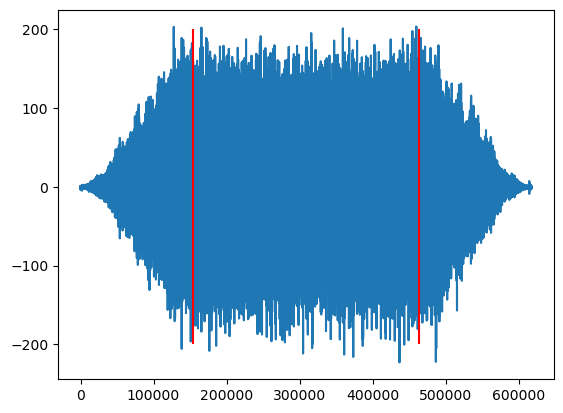

In [31]:
swap = pd.read_csv(os.path.join(raw_data_folder, "ARotor_replication", "1000rpm_CT_baseline_11%_GP8_0.csv"))
plt.plot(swap["acc1"])
plt.vlines([len(swap) * 0.25, len(swap) * 0.75], -200, 200, color="r")
swap.to_feather(os.path.join(raw_data_folder, "ARotor_replication", "1000rpm_CT_baseline_11%_GP8_0.feather"))
